# Classification du genre et régression pour l'âge (modèle 3)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/R505/UTKFace_only.zip" -d "/content/UTKFace"

In [3]:
# Importation
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, RandomFlip, RandomRotation, RandomZoom, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importation de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, accuracy_score

In [4]:
DATA_DIR = "/content/UTKFace/UTKFace"

In [5]:
#Redimensionnement
IMG_HEIGHT = 64
IMG_WIDTH = 64

## Chargement et Prétraitement des Images, Extraction des genres et des âges

L’objectif de cette étape est de préparer les données du dataset UTKFace afin d’entraîner un modèle qui fera à la fois de la classification pour la prédiction des genres (comme le Modèle 1) et de la régression pour la prédiction de l'âge (comme le Modèle 2).

In [6]:
def load_data_age(data_dir=DATA_DIR, img_size=(64,64)):
    X = []
    y = []
    file_names = os.listdir(data_dir)

    for file in file_names:
        parts = file.split("_")
        if len(parts) > 1:
            try:
                age = int(parts[0]) # Extraction de l'âge (1ère partie du nom de fichier)
                gender = int(parts[1]) # Le deuxième élément est le sexe (0 = Homme, 1 = Femme)
            except:
                continue

            img_path = os.path.join(data_dir, file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            # RGB + Resize + Normalisation
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype("float32") / 255.0

            X.append(img)
            y.append((gender, age))

    return np.array(X), np.array(y)

X, y = load_data_age(DATA_DIR, (IMG_HEIGHT, IMG_WIDTH))
print("Nombre d'images chargées :", len(X))
print("Dimension de X :", X.shape, "Dimension de y :", y.shape)


Nombre d'images chargées : 23708
Dimension de X : (23708, 64, 64, 3) Dimension de y : (23708, 2)


Ce code effectue:

- Un chargement de chaque image du dataset en lisant son chemin d’accès.
- Une extraction de l’âge à partir du nom du fichier.
- Une conversion des images en format RGB, (car cv2.imread() charge les images en BGR par défaut.)
- Un redimensionnement en 64×64 pixels, afin de réduire la taille mémoire et uniformiser les entrées du modèle.
- Une normalisation des pixels entre [0,1], pour faciliter l’entraînement et accélère la convergence.

## Division du jeu de données

Une fois les images et leurs âges récupérés, le dataset est divisé en trois parties :

In [7]:
# Split Train / Val / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42
)

print("Taille du jeu d'entraînement :", X_train.shape, len(y_train))
print("Taille du jeu de validation :", X_val.shape, len(y_val))
print("Taille du jeu de test :", X_test.shape, len(y_test))

y_train_gender = np.array([y[0] for y in y_train])
y_train_age = np.array([y[1] for y in y_train])

y_val_gender = np.array([y[0] for y in y_val])
y_val_age = np.array([y[1] for y in y_val])

print("\nTaille de y_train_gender :", y_train_gender.shape)
print("Taille de y_train_age :", y_train_age.shape)
print("Taille de y_val_gender :", y_val_gender.shape)
print("Taille de y_val_age :", y_val_age.shape)


Taille du jeu d'entraînement : (15172, 64, 64, 3) 15172
Taille du jeu de validation : (3794, 64, 64, 3) 3794
Taille du jeu de test : (4742, 64, 64, 3) 4742

Taille de y_train_gender : (15172,)
Taille de y_train_age : (15172,)
Taille de y_val_gender : (3794,)
Taille de y_val_age : (3794,)


- L’entraînement permet au modèle d’apprendre sur une grande quantité de données.
- La validation permet d’ajuster l’entraînement et de détecter si le modèle commence à mémoriser les données (surapprentissage).
- Le test est une évaluation finale sur un ensemble de données non utilisées, afin de mesurer la généralisation du modèle.

## Définition des tranches d'âges

On utilise les tranches d'âge de la V2 du modèle 2

In [8]:
age_brackets = [
    (0, 3),    # Nourrissons
    (4, 9),    # Jeune enfant
    (10, 19),  # Adolescents
    (20, 39),  # Jeunes adultes (fusion de 20-29 et 30-39)
    (40, 59),  # Adultes (fusion de 40-49 et 50-59)
    (60, 116)  # Seniors (fusion de 60-69, 70-79 et 80-116)
]

In [9]:
def bracket_index(age):
    for i, (low, high) in enumerate(age_brackets):
        if low <= age <= high:
            return i
    return None

En effet, les erreurs en régression peuvent être trop pénalisantes (en termes de stats) si le modèle prédit un âge légèrement incorrect (ex. 21 ans au lieu de 22 ans).

Ainsi, en regroupant les âges en catégories cohérentes, on réduit l’impact des erreurs.

# Implémentation

On se base sur la V2 du modèle 1 et la V2 du modèle 2 et on les met dans le même modèle

In [13]:
# Modèle de la première consigne, adapté pour la régression d'âge

def build_model_gender_age_v1(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    model_input_layer = Input(shape=input_shape)
    model_common_layer = RandomFlip("horizontal")(model_input_layer)
    model_common_layer = RandomRotation(0.1)(model_common_layer)
    model_common_layer = RandomZoom(0.1)(model_common_layer)

    # Bloc 1
    model_common_layer = Conv2D(16, (3, 3), activation='relu', padding='same')(model_common_layer)
    model_common_layer = BatchNormalization()(model_common_layer)
    model_common_layer = MaxPooling2D((2, 2))(model_common_layer)

    # Bloc 2
    model_common_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(model_common_layer)
    model_common_layer = BatchNormalization()(model_common_layer)
    model_common_layer = MaxPooling2D((2, 2))(model_common_layer)

    # Bloc 3
    model_common_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(model_common_layer)
    model_common_layer = BatchNormalization()(model_common_layer)
    model_common_layer = MaxPooling2D((2, 2))(model_common_layer)

    # Bloc 4
    model_common_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(model_common_layer)
    model_common_layer = BatchNormalization()(model_common_layer)
    model_common_layer = MaxPooling2D((2, 2))(model_common_layer)

    # Bloc 5
    model_common_layer = Conv2D(256, (3,3), activation='relu', padding='same')(model_common_layer)
    model_common_layer = BatchNormalization()(model_common_layer)
    model_common_layer = MaxPooling2D((2,2))(model_common_layer)

    model_common_layer = Flatten()(model_common_layer)

    # --- Bloc genre ---

    # Couche Dense + Dropout
    model_gender_layer = Dense(256, activation='relu')(model_common_layer)
    model_gender_layer = BatchNormalization()(model_gender_layer)
    model_gender_layer = Dropout(0.5)(model_gender_layer)

    # Sortie binaire (Homme/Femme)
    model_gender_layer = Dense(1, activation='sigmoid', name="gender")(model_gender_layer)

    # --- Bloc âge ---

    model_age_layer = Dense(256, activation='relu')(model_common_layer)
    model_age_layer = BatchNormalization()(model_age_layer)
    model_age_layer = Dropout(0.4)(model_age_layer)

    # Sortie régression => 1 neurone (pas de sigmoid)
    model_age_layer = Dense(1, activation='linear', name="age")(model_age_layer)


    # Fin des couches

    model = Model(inputs=model_input_layer, outputs=[model_gender_layer, model_age_layer])

    # Compilation : Utilisation de MAE comme fonction de perte pour la régression
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={"gender": "binary_crossentropy", "age": "mae"},
        metrics={"gender": "accuracy", "age": "mae"},
        loss_weights={"gender": 4, "age": 1} # Pour éviter que le faible loss par défaut de gender fasse que le modèle ne se concentre que sur l'âge
    )
    return model


model_v1 = build_model_gender_age_v1((IMG_HEIGHT, IMG_WIDTH, 3))
model_v1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_2             │ (None, 64, 64, 3)      │              0 │ input_layer_2[0][0]    │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_2         │ (None, 64, 64, 3)      │              0 │ random_flip_2[0][0]    │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_2             │ (None, 64, 64, 3)      │              0 │ random_rotation_2[0][… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 16)     │            448 │ random_zoom_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 64, 64, 16)     │             64 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 16)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 32)     │          4,640 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 32, 32, 32)     │            128 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 16, 16, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 16, 16, 64)     │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 921,954 (3.52 MB)

 Trainable params: 919,938 (3.51 MB)

 Non-trainable params: 2,016 (7.88 KB)

In [14]:
# Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    min_lr=1e-5
)

history_v1 = model_v1.fit(
    X_train,
    (y_train_gender, y_train_age),
    validation_data=(X_val, (y_val_gender, y_val_age)),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - age_loss: 27.4661 - age_mae: 27.4662 - gender_accuracy: 0.6753 - gender_loss: 0.7091 - loss: 30.3027 - val_age_loss: 11.4998 - val_age_mae: 11.4987 - val_gender_accuracy: 0.7818 - val_gender_loss: 0.4568 - val_loss: 13.3246 - learning_rate: 0.0010
Epoch 2/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - age_loss: 11.3816 - age_mae: 11.3816 - gender_accuracy: 0.7775 - gender_loss: 0.4733 - loss: 13.2746 - val_age_loss: 11.7728 - val_age_mae: 11.7651 - val_gender_accuracy: 0.8195 - val_gender_loss: 0.4070 - val_loss: 13.3949 - learning_rate: 0.0010
Epoch 3/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - age_loss: 10.2856 - age_mae: 10.2857 - gender_accuracy: 0.8118 - gender_loss: 0.4043 - loss: 11.9030 - val_age_loss: 9.6749 - val_age_mae: 9.6770 - val_gender_accuracy: 0.8513 - val_gender_loss: 0.3317 - val_loss: 11.0046 - learning_rate: 0.0010
Epoch 4/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - age_loss: 9.6481 - age_mae: 9.

# Analyse des résultats

### Analyse des métriques

Voici les résultats obtenus après l’entraînement du modèle sur l’ensemble de test.

L’objectif est d’analyser si il y a des axes d'amélioration possible

In [20]:
y_test_gender = np.array([y[0] for y in y_test])
y_test_age = np.array([y[1] for y in y_test])

test_loss_total, test_loss_gender_v1, test_loss_age_v1, test_mae_v1, test_accuracy_v1 = model_v1.evaluate(X_test, (y_test_gender, y_test_age), verbose=0)
print(f"[V1] Total: Test Loss: {test_loss_total:.4f}")
print(f"[V1] Genre: Test Accuracy: {test_accuracy_v1:.4f} | Loss: {test_loss_gender_v1:.4f}")
print(f"[V1] Âge: Test MAE: {test_mae_v1:.4f} | Loss: {test_loss_age_v1:.4f}")

y_pred_v1_test = model_v1.predict(X_test)
y_pred_v1_test = (y_pred_v1_test[0].flatten(), y_pred_v1_test[1].flatten())
y_pred_v1_test_gender = y_pred_v1_test[0]
y_pred_v1_test_age = y_pred_v1_test[1]


# Prédictions pour Genre

# Prédictions sur le jeu de test
y_pred_test_gender = (y_pred_v1_test_gender > 0.5).astype("int32")
print(f"[V1] Genre: Test Accuracy (true): {accuracy_score(y_test_gender, y_pred_test_gender)}")

# Rapport de classification pour le jeu de test
print("\n[V1] Classification report sur les genres sur TEST:")
print(classification_report(y_test_gender, y_pred_test_gender, target_names=["Homme", "Femme"]))

# ---

# Prédictions pour Age
data_index = 1
data_name = "Âge"

y_pred_brackets_v1_test_age = [bracket_index(int(round(predict_data))) for predict_data in y_pred_v1_test_age]
y_test_brackets_v1_age = [bracket_index(int(true_data)) for true_data in y_test_age]

valid_idx_test_age = [i for i, br in enumerate(y_pred_brackets_v1_test_age) if br is not None]
y_pred_brackets_v1_test_age_valid = np.array([y_pred_brackets_v1_test_age[i] for i in valid_idx_test_age], dtype=int)
y_test_brackets_v1_age_valid = np.array([y_test_brackets_v1_age[i] for i in valid_idx_test_age], dtype=int)

acc_brackets_v1_test = accuracy_score(y_test_brackets_v1_age_valid, y_pred_brackets_v1_test_age_valid)
print(f"\n[V1] Accuracy ({data_name}) :", acc_brackets_v1_test)

print(f"\n[V1] Classification report sur les tranches d'âge sur TEST ({data_name}):")
print(classification_report(y_test_brackets_v1_age_valid, y_pred_brackets_v1_test_age_valid))

[V1] Total: Test Loss: 6.7068
[V1] Genre: Test Accuracy: 0.9123 | Loss: 0.2041
[V1] Âge: Test MAE: 5.8862 | Loss: 5.8783
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[V1] Genre: Test Accuracy (true): 0.9122733024040489

[V1] Classification report sur les genres sur TEST:
              precision    recall  f1-score   support

       Homme       0.92      0.91      0.92      2477
       Femme       0.90      0.91      0.91      2265

    accuracy                           0.91      4742
   macro avg       0.91      0.91      0.91      4742
weighted avg       0.91      0.91      0.91      4742


[V1] Accuracy (Âge) : 0.7407721680101824

[V1] Classification report sur les tranches d'âge sur TEST (Âge):
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       349
           1       0.47      0.51      0.49       245
           2       0.47      0.33      0.39       304
           3       0.82      0.90      0.85      2384
           4       0.60  

Lors d'une exécution précédente, dont les logs ne sont pas restés ici, on s'est rendu compte que le modèle avait de mauvaises valeurs (0.88 environ) pour la prédiction de genre. Il s'est avéré que le genre générait une valeur loss beaucoup plus faible que la prédiction d'âge, ce qui fait que le modèle se concentrait principalement sur la prédiction de l'âge et non l'amélioration de la prédiction de genre.

Nous avons donc implémenté un poids de 4 (x4 sur le loss de base) et le problème a été corrigé. L'accuracy est passée à 0.91

Nous avons également augmenté la patience du ReduceLROnPlateau et du EarlyStopping, ce qui a permis au modèle de davantage s'améliorer et passer à 0.74 d'accuracy au lieu de 0.71 sur le modèle 2.

Globalement, le f1-score pour toutes les tranches d'âge s'est légèrement amélioré également.

In [21]:
y_val_gender = np.array([y[0] for y in y_val])
y_val_age = np.array([y[1] for y in y_val])

val_loss_total, val_loss_gender_v1, val_loss_age_v1, val_mae_v1, val_accuracy_v1 = model_v1.evaluate(X_val, (y_val_gender, y_val_age), verbose=0)
print(f"[V1] Genre: Validation Accuracy: {val_accuracy_v1:.4f} | Loss: {val_loss_gender_v1:.4f}")
print(f"[V1] Âge: Validation MAE: {val_mae_v1:.4f} | Loss: {val_loss_age_v1:.4f}")

y_pred_v1_val = model_v1.predict(X_val)
y_pred_v1_val = (y_pred_v1_val[0].flatten(), y_pred_v1_val[1].flatten())
y_pred_v1_val_gender = y_pred_v1_val[0]
y_pred_v1_val_age = y_pred_v1_val[1]

# Prédictions pour Genre

# Prédictions sur le jeu de validation
y_pred_val_gender = (y_pred_v1_val_gender > 0.5).astype("int32")
print(f"[V1] Genre: Validation Accuracy (true): {accuracy_score(y_val_gender, y_pred_val_gender)}")

# Rapport de classification pour le jeu de validation
print("\n[V1] Classification report sur les genres sur VALIDATION:")
print(classification_report(y_val_gender, y_pred_val_gender, target_names=["Homme", "Femme"]))

# ---

# Prédictions pour Age

data_index = 1
data_name = "Âge"

y_pred_brackets_v1_val_age = [bracket_index(int(round(predict_data))) for predict_data in y_pred_v1_val_age]
y_val_brackets_v1_age = [bracket_index(int(true_data)) for true_data in y_val_age]

valid_idx_val_age = [i for i, br in enumerate(y_pred_brackets_v1_val_age) if br is not None]
y_pred_brackets_v1_val_valid_age = np.array([y_pred_brackets_v1_val_age[i] for i in valid_idx_val_age], dtype=int)
y_val_brackets_v1_valid_age = np.array([y_val_brackets_v1_age[i] for i in valid_idx_val_age], dtype=int)

acc_brackets_v1_val = accuracy_score(y_val_brackets_v1_valid_age, y_pred_brackets_v1_val_valid_age)
print(f"\n[V1] Accuracy ({data_name}) :", acc_brackets_v1_val)

print(f"\n[V1] Classification report sur les tranches d'âge sur VALIDATION ({data_name}):")
print(classification_report(y_val_brackets_v1_valid_age, y_pred_brackets_v1_val_valid_age))


[V1] Genre: Validation Accuracy: 0.9043 | Loss: 0.2158
[V1] Âge: Validation MAE: 5.7863 | Loss: 5.7892
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[V1] Genre: Validation Accuracy (true): 0.904322614654718

[V1] Classification report sur les genres sur VALIDATION:
              precision    recall  f1-score   support

       Homme       0.91      0.90      0.91      1954
       Femme       0.90      0.91      0.90      1840

    accuracy                           0.90      3794
   macro avg       0.90      0.90      0.90      3794
weighted avg       0.90      0.90      0.90      3794


[V1] Accuracy (Âge) : 0.7292275019909743

[V1] Classification report sur les tranches d'âge sur VALIDATION (Âge):
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       281
           1       0.44      0.47      0.45       176
           2       0.52      0.36      0.43       275
           3       0.79      0.88      0.84      1842
           4       0.59   

L’objectif ici est de vérifier si les améliorations observées sur le jeu de test se confirment sur le jeu de validation.

Cela nous permet d’évaluer si le modèle est stable et généralisable.

Il semblerait que le modèle ait des scores légèrement inférieurs sur le set de Validation par rapport au set de Test, ce qui est rare, le set de Validation étant utilisé pour l'entrainement. Cela indique qu'il a une plutôt bonne capacité de généralisation, et qu'il n'y a pas de sur-apprentissage.

### Visualisations : diagrammes de points, courbes d'apprentissage

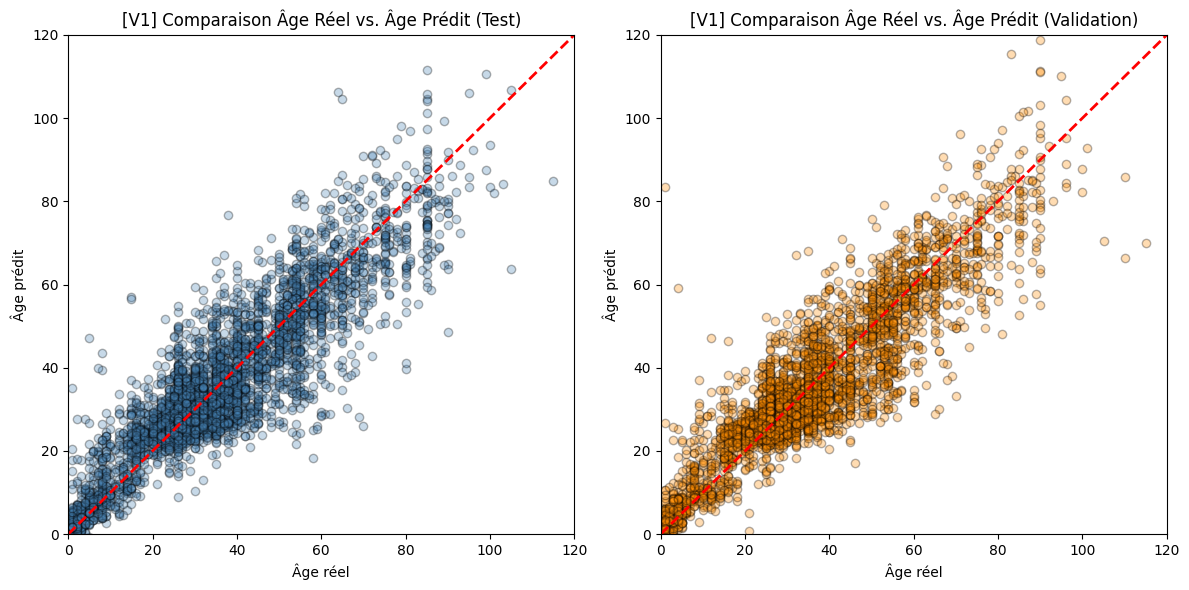

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))  # 1 ligne, 2 colonnes

# Scatter plot : Comparaison âge réel vs âge prédit (TEST)
axes[0].scatter(y_test_age, y_pred_v1_test_age, alpha=0.3, color='steelblue', edgecolor='k')
axes[0].plot([0,120],[0,120], color='red', linestyle='--', linewidth=2)  # Diagonale parfaite
axes[0].set_xlabel("Âge réel")
axes[0].set_ylabel("Âge prédit")
axes[0].set_title("[V1] Comparaison Âge Réel vs. Âge Prédit (Test)")
axes[0].set_xlim([0,120])
axes[0].set_ylim([0,120])

# Scatter plot : Comparaison âge réel vs âge prédit (VALIDATION)
axes[1].scatter(y_val_age, y_pred_v1_val_age, alpha=0.3, color='darkorange', edgecolor='k')
axes[1].plot([0,120],[0,120], color='red', linestyle='--', linewidth=2)  # Diagonale parfaite
axes[1].set_xlabel("Âge réel")
axes[1].set_ylabel("Âge prédit")
axes[1].set_title("[V1] Comparaison Âge Réel vs. Âge Prédit (Validation)")
axes[1].set_xlim([0,120])
axes[1].set_ylim([0,120])

plt.tight_layout()  # Ajuste l'espacement entre les graphiques
plt.show()


Les deux graphiques présentent une distribution similaire, ce qui indique que le modèle généralise bien et ne souffre pas de surapprentissage.

La tendance à sous-estimer les âges avancés est présente dans les deux ensembles, confirmant que c’est une faiblesse du modèle.

En effet, la majorité des points après 60 ans se situent sous la diagonale, ce qui signifie que le modèle prédit des âges trop jeunes pour ces visages. Cela reste similaire aux modèles et itérations précédentes.

Cependant, concernant les âges 20-39 ans, les points sont bien alignés sur la diagonale, confirmant que le modèle est performant pour cette tranche d’âge.

Obtenir les mêmes résultats que le 2ème modèle est rassurant, une architecture extrêmement similaire ayant été utilisée.

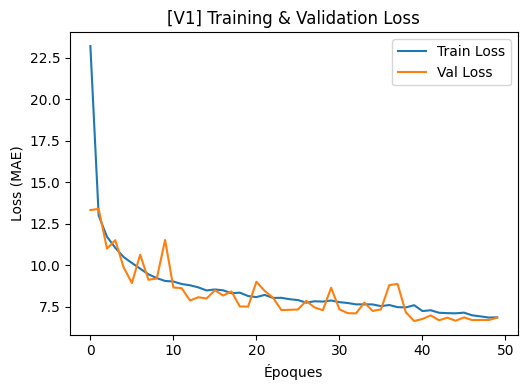

In [23]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_v1.history['loss'], label='Train Loss')
plt.plot(history_v1.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.title('[V1] Training & Validation Loss')

plt.tight_layout()
plt.show()


Ce graphique représente l’évolution de la loss (MAE - Mean Absolute Error) au cours des époques pour l'entraînement et la validation du modèle.

L’objectif est d’évaluer la convergence du modèle, son potentiel surapprentissage et sa stabilité.

Entre 0 et 5 époques, la loss d'apprentissage chute rapidement. Cela indique que le modèle apprend efficacement dès le départ.

La loss de validation semble descendre petit a petit avec des petits pics occasionels jusqu'à stagner vers 6-7 MAE à partir de l'époque 40, indiquant un début de surapprentissage, qui est évité par le EarlyStopping.

La convergence est bien visible, montrant que le modèle a atteint un plateau d'apprentissage.

Le modèle n'a pas l'air de souffrir d'overfitting grâce au EarlyStopping.

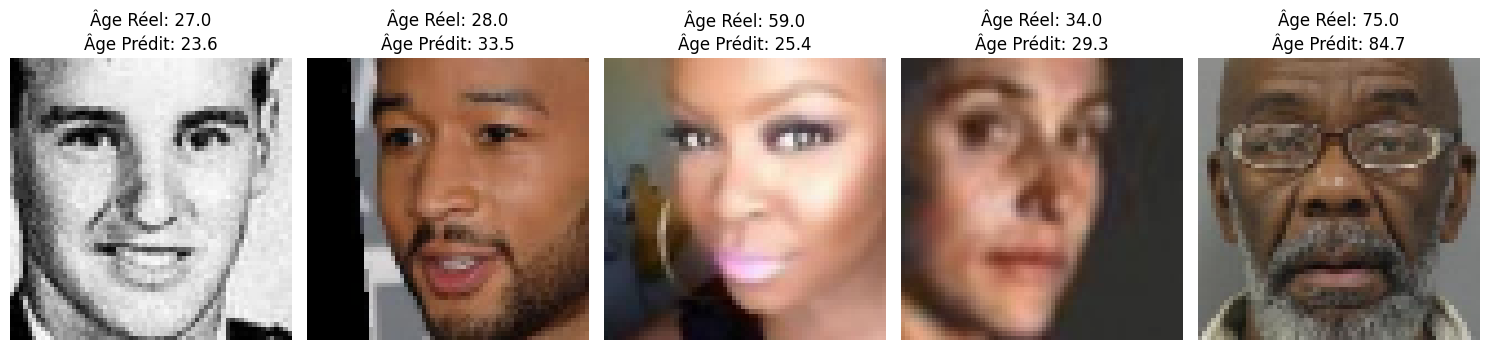

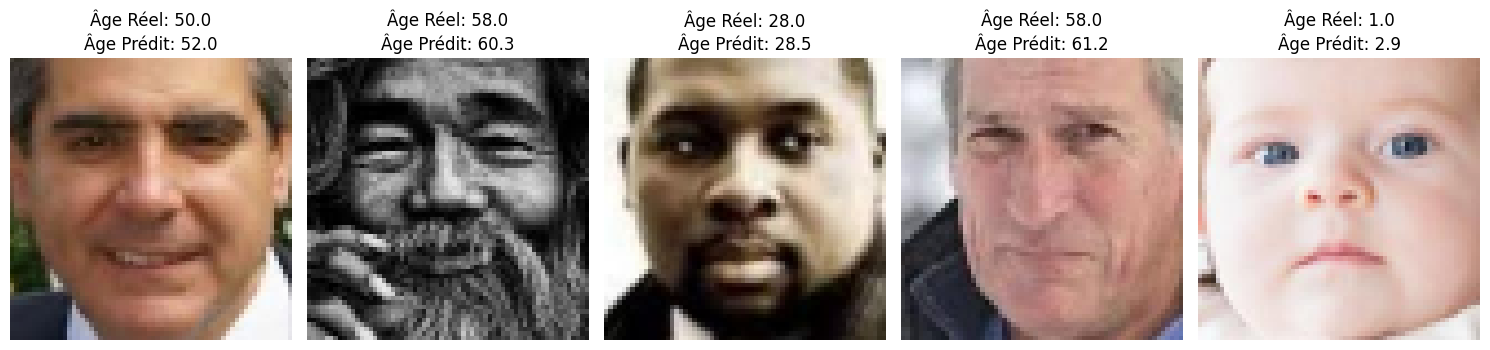

In [24]:
def visualize_predictions(X, y_true, y_pred, n=5):
    """
    Affiche n images avec l'âge réel et l'âge prédit.
    """
    import random
    indices = random.sample(range(len(X)), n)  # Sélection aléatoire d'images
    plt.figure(figsize=(15, 3*n))

    for i, idx in enumerate(indices):
        ax = plt.subplot(1, n, i+1)
        img = X[idx]  # Image correspondante
        plt.imshow(img)
        real_age = y_true[idx]  # Âge réel
        pred_age = y_pred[idx]  # Âge prédit
        ax.set_title(f"Âge Réel: {real_age:.1f}\nÂge Prédit: {pred_age:.1f}")
        ax.axis('off')  # Supprime les axes

    plt.tight_layout()
    plt.show()

# Test
visualize_predictions(X_test, y_test_age, y_pred_v1_test_age, n=5)

# Validation
visualize_predictions(X_val, y_val_age, y_pred_v1_val_age, n=5)


En conclusion, le modèle V4 (qui est noté ici V1) possède de meilleures prédictions que le modèle 2 pour l'âge et des prédictions similaires au modèle 1 pour le genre, et cela grâce à l'augmentation de la patience du EarlyStopping et du ReduceLROnPlateau afin de laisser au modèle le temps de se préciser sans néanmoins aller jusqu'à l'overfitting.

De ce fait, nous sauvegarderons ce modèle sous le nom V4.

In [25]:
model_v1.save("model_v4_Q3.keras")
model_v1.save("/content/drive/MyDrive/R505/model_v4_Q3.keras")

In [ ]:
from google.colab import files
files.download("model_v4_Q3.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>